In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier


# Mission

Dans un premier notebook, les posts tagués ont été extraits, et prétraités. De ce travail, les textes sont laissés sous forme de "bag of word", une liste de mots d'intérêt appelés tokens. Pour les variables de sortie dans l'apprentissage supervisé, seulement quelques tags sont gardés, afin de limiter la complexité de calculs. Il sera possible de généraliser cela.

## Rappel des consignes :

* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.


## Livrable attendu ici
Un notebook de test de différents modèles (non cleané, pour comprendre votre démarche)


# Ressources : 
## LDA 
* Une explication générale : https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2
* Un cours plus détaillé (approche plus proba) : https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiykLO95Yj1AhWkzYUKHT2hBI4QFnoECAUQAQ&url=http%3A%2F%2Falberto.bietti.me%2Ffiles%2Frapport-lda.pdf&usg=AOvVaw1tuLV60ncpf3PIqb3PN0DE
* 3eme ressource : https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/


* LDA sklearn documentation : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
## Gradient Boosting :

# Plan du notebook :

Pour faciliter la lecture, il est possible de revenir à ce sommaire, en cliquant sur [back to menu](#menu) chaque fois qu'il apparaît. A partir de ce menu, il est possible de naviguer entre les parties en cliquant sur leur titre.


<a id ="menu"></a>
1. [Les posts](#section1)
    1. [Import du travail précédent](#section1.1)
    2. [Séparation des données](#section1.2)
    
2. [Approche non supervisée](#section2)
    1. [LDA - code de base](#section2.1)
    2. [Comparaison LDA/NMF](#section2.2)
    3. [Optimisation des hyper-paramètres du LDA](#section2.3)
    4. [LDA - modèle sur test](#section2.4)
3. [Approche supervisée](#section3)
    1. [Gradient Boosting](#section3.1)
        2. [](#section3.1.1)
        3. [](#section3.1.2)
        4. [](#section3.1.3)   
    2. [Bert ?](#section3.2)
        1. [](#section3.2.1)
        2. [](#section3.2.2)
        3. [](#section3.2.3)       
        4. [](#section3.2.4)

<a id ="section1"></a>
<a id ="section1.1"></a>

[back to menu](#menu)

# 1.Les posts
## 1.A Import du travail précédent

In [2]:
## original text : 
with open(res_path + "corpora_title_body.pkl", 'rb') as f:
    save_corpora = pickle.load(f)

## Posts Lemmatized :
with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
len(corpora)

11095

Comme proposé dans [ce post](https://thatascience.com/learn-machine-learning/save/), j'utilise la fonction "CountVectorizer" de sklearn pour passer en one ot encoding (sans visualisation possible car matrice sparse)

In [3]:
countvec = CountVectorizer(ngram_range=(1,4), 
                           stop_words='english',  
                           strip_accents='unicode',
                           max_features=10000)
X = countvec.fit_transform(pd.Series(corpora))
X

<11095x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 325452 stored elements in Compressed Sparse Row format>

In [4]:
X_df = pd.DataFrame(X.toarray(), index=corpora.keys())

In [5]:
## passer en list de tokens : 
# {k:text.split(" ") for k,text in corpora.items()}

In [6]:
## tags :
## df tags :
df_tags = pd.read_csv(res_path + "tags_preprocessed_table.csv", index_col=0)

## one of the original tags :
with open(res_path+"y_uniclass"+".pkl", "rb") as f :
    y = pickle.load(f)
    
## 3 meta-tags from clustering :
with open(res_path+"y_multiclass"+".pkl", "rb") as f :
    Y = pickle.load(f)

<a id ="section1.2"></a>
[back to menu](#menu)


## 1.B Séparation des posts 

Pour comparer les données, je vais séparer mon ensemble de posts en apprentissage et test. Le premier servira à apprendre les modèles, le deuxième à comparer les prédictions entre les différents modèles 

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_df)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
25182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56843,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Et pour avoir accès aux indices : 

In [8]:
train_index = X_train.index#pd.DataFrame(X.toarray(), index = list(corpora.keys())).iloc[X_train.indices,:].index
test_index = X_test.index

Pour être consistant entre les modèles suivants, j'enregistre cette spéaration train/test : 

In [9]:
# with open(res_path+"train_test_split"+".pkl", "wb") as f :
#     pickle.dump((train_index,test_index), f, pickle.HIGHEST_PROTOCOL)

Je peux donc partir de cette cellule pour la suite : 

In [10]:
## open corpora : 
with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
## import train/test split index :    
with open(res_path+"train_test_split"+".pkl", "rb") as f :
    (train_index,test_index) = pickle.load(f)

n_features = 1000 
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

<a id ="section1.3"></a>
[back to menu](#menu)

## 1.C Séparation des tags 
J'utilise le même index pour extraire les tags de train et test : 
### Univarié (label le plus fréquent)

In [12]:
y_train = y[train_index]
y_test = y[test_index]

### Multivarié (clustering donné sur les tags) :

In [13]:
Y_train = Y.loc[train_index]
Y_test = Y.loc[test_index]

<a id ="section2"></a>
<a id ="section2.1"></a>
[back to menu](#menu)

# 2. Approche non supervisé
## 2.A LDA - code de base 
Pour lancer la LDA, la [documentation de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) est très claire. [Cet article](https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6) propose un tuto pour l'implémentation. A noter : gensim propose aussi une implémentation de la LDA, [qui avait l'air assez facile à prendre en main](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [123]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_train)

LatentDirichletAllocation(n_components=5, random_state=0)

In [346]:
lda.transform(X_test)

array([[5.52925013e-01, 1.67497105e-02, 3.96442572e-01, 1.67152722e-02,
        1.71674324e-02],
       [8.68368357e-01, 8.07268432e-03, 8.22684357e-03, 8.07177979e-03,
        1.07260336e-01],
       [5.75771957e-04, 5.62578844e-04, 7.69020420e-02, 5.63969134e-04,
        9.21395638e-01],
       ...,
       [5.65180521e-03, 6.53946784e-01, 5.73821606e-03, 3.28934805e-01,
        5.72838956e-03],
       [6.10911659e-01, 7.83239771e-03, 7.98487692e-03, 1.64698251e-01,
        2.08572815e-01],
       [7.78156029e-03, 7.78756336e-03, 7.91302881e-03, 7.32659742e-01,
        2.43858106e-01]])

Pour interpréter les résultats cependant, ce n'est pas si simple. D'autant qu'il faut tester différentes valeurs de n_components, mais aussi le learning_decay. Pour aller plus vite, penser à choisir n_jobs (parallèlisation) 

<a id ="section2.2"></a>
[back to menu](#menu)

## 2.B Comparaison LDA/NMF 
[Une page de scikit](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py) propose de comparer différentes méthodes d'extraction de topic. J'ai modifié le code pour le lancer sur mes postes stackoverflow : 

In [347]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time.time()
data_samples = [corpora[k] for k in train_index]
print("done in %0.3fs." % (time.time() - t0))

Loading dataset...
done in 0.002s.


In [348]:
n_features = 1000
n_components = 10
n_samples = 2000
n_top_words = 20

In [389]:
def plot_top_words(model, feature_names, n_top_words, title, n5 = 2):
    ## n5 = number of lines filled will 5 plot
    fig, axes = plt.subplots(n5, 5, figsize=(30, 6*n5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:5*n5]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

In [390]:
## Preprocess text :

# Use tf-idf features for NMF 
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, )
    #stop_words="english") ## already removed
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features,# stop_words="english"
)
t0 = time.time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))
print()

Extracting tf-idf features for NMF...
done in 0.156s.
Extracting tf features for LDA...
done in 0.159s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.123s.


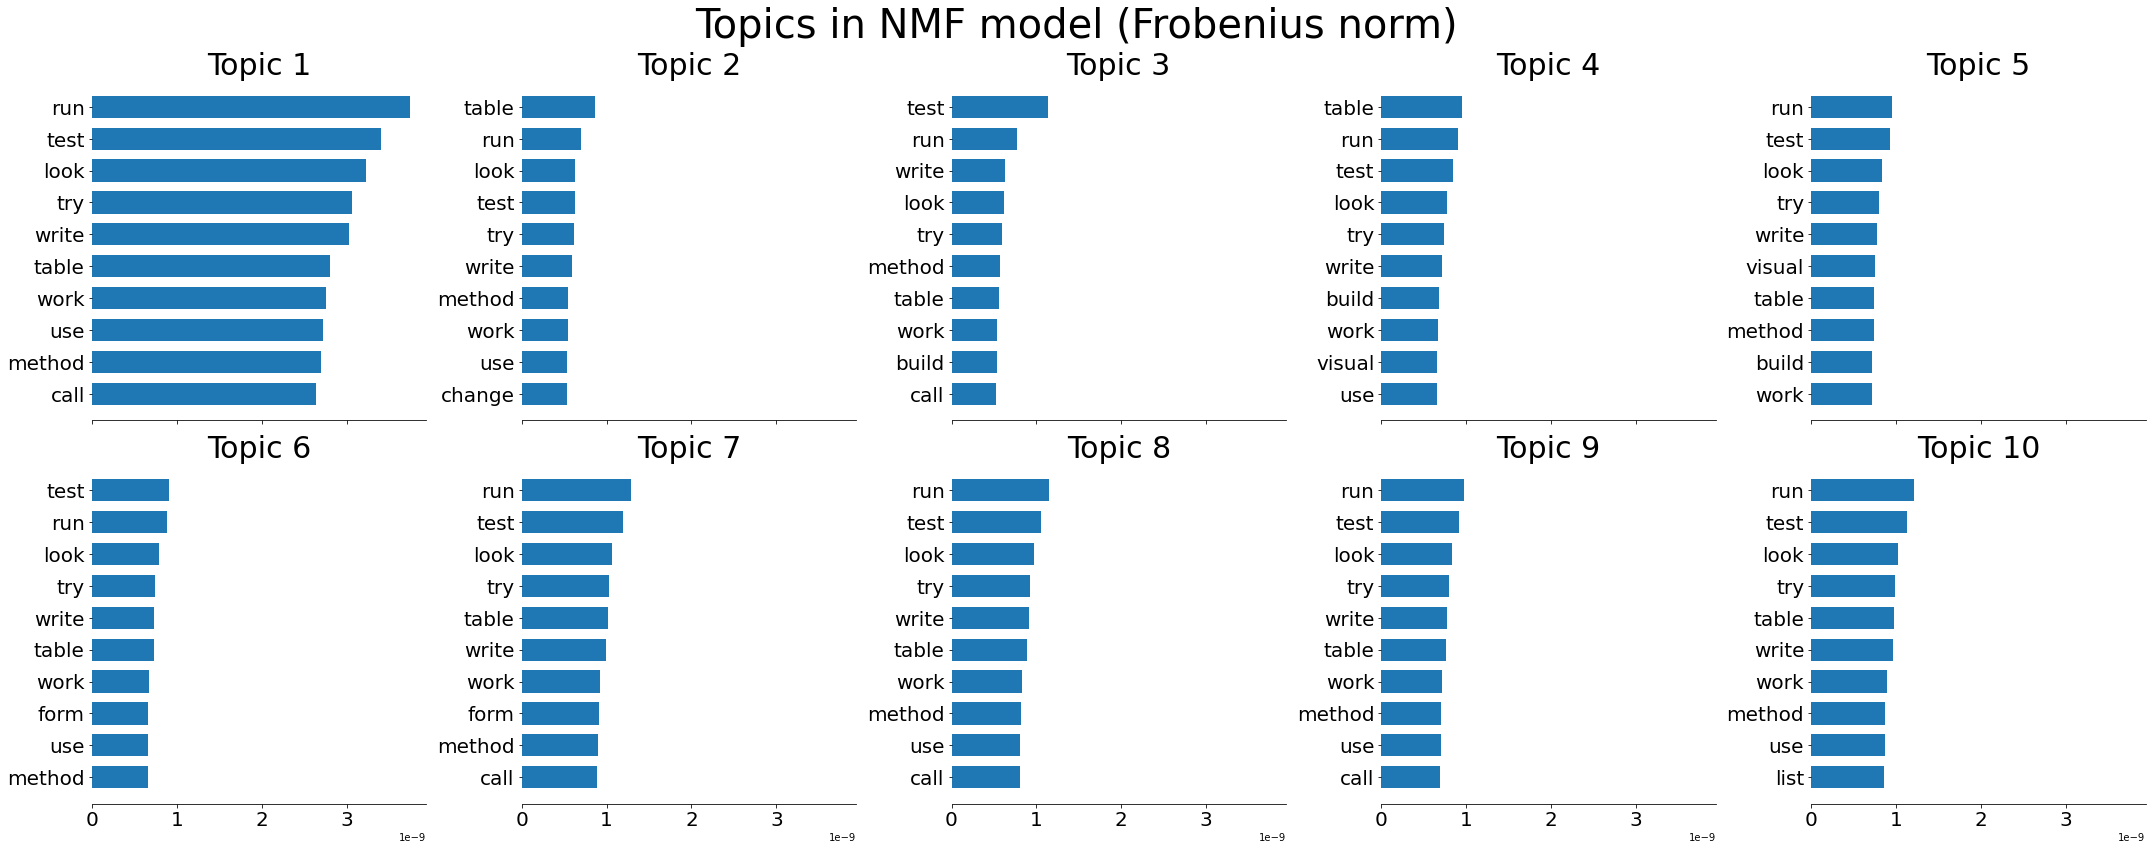

In [391]:
# Fit the NMF model with Frobenius norm :
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time.time()
nmf = NMF(n_components=n_components, 
          init='nndsvd', #random_state=1,
          alpha_W=0.1, alpha_H="same", l1_ratio=0) ## pas de pénalisation L1 sinon 0 partout
nmf = nmf.fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words( nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.584s.


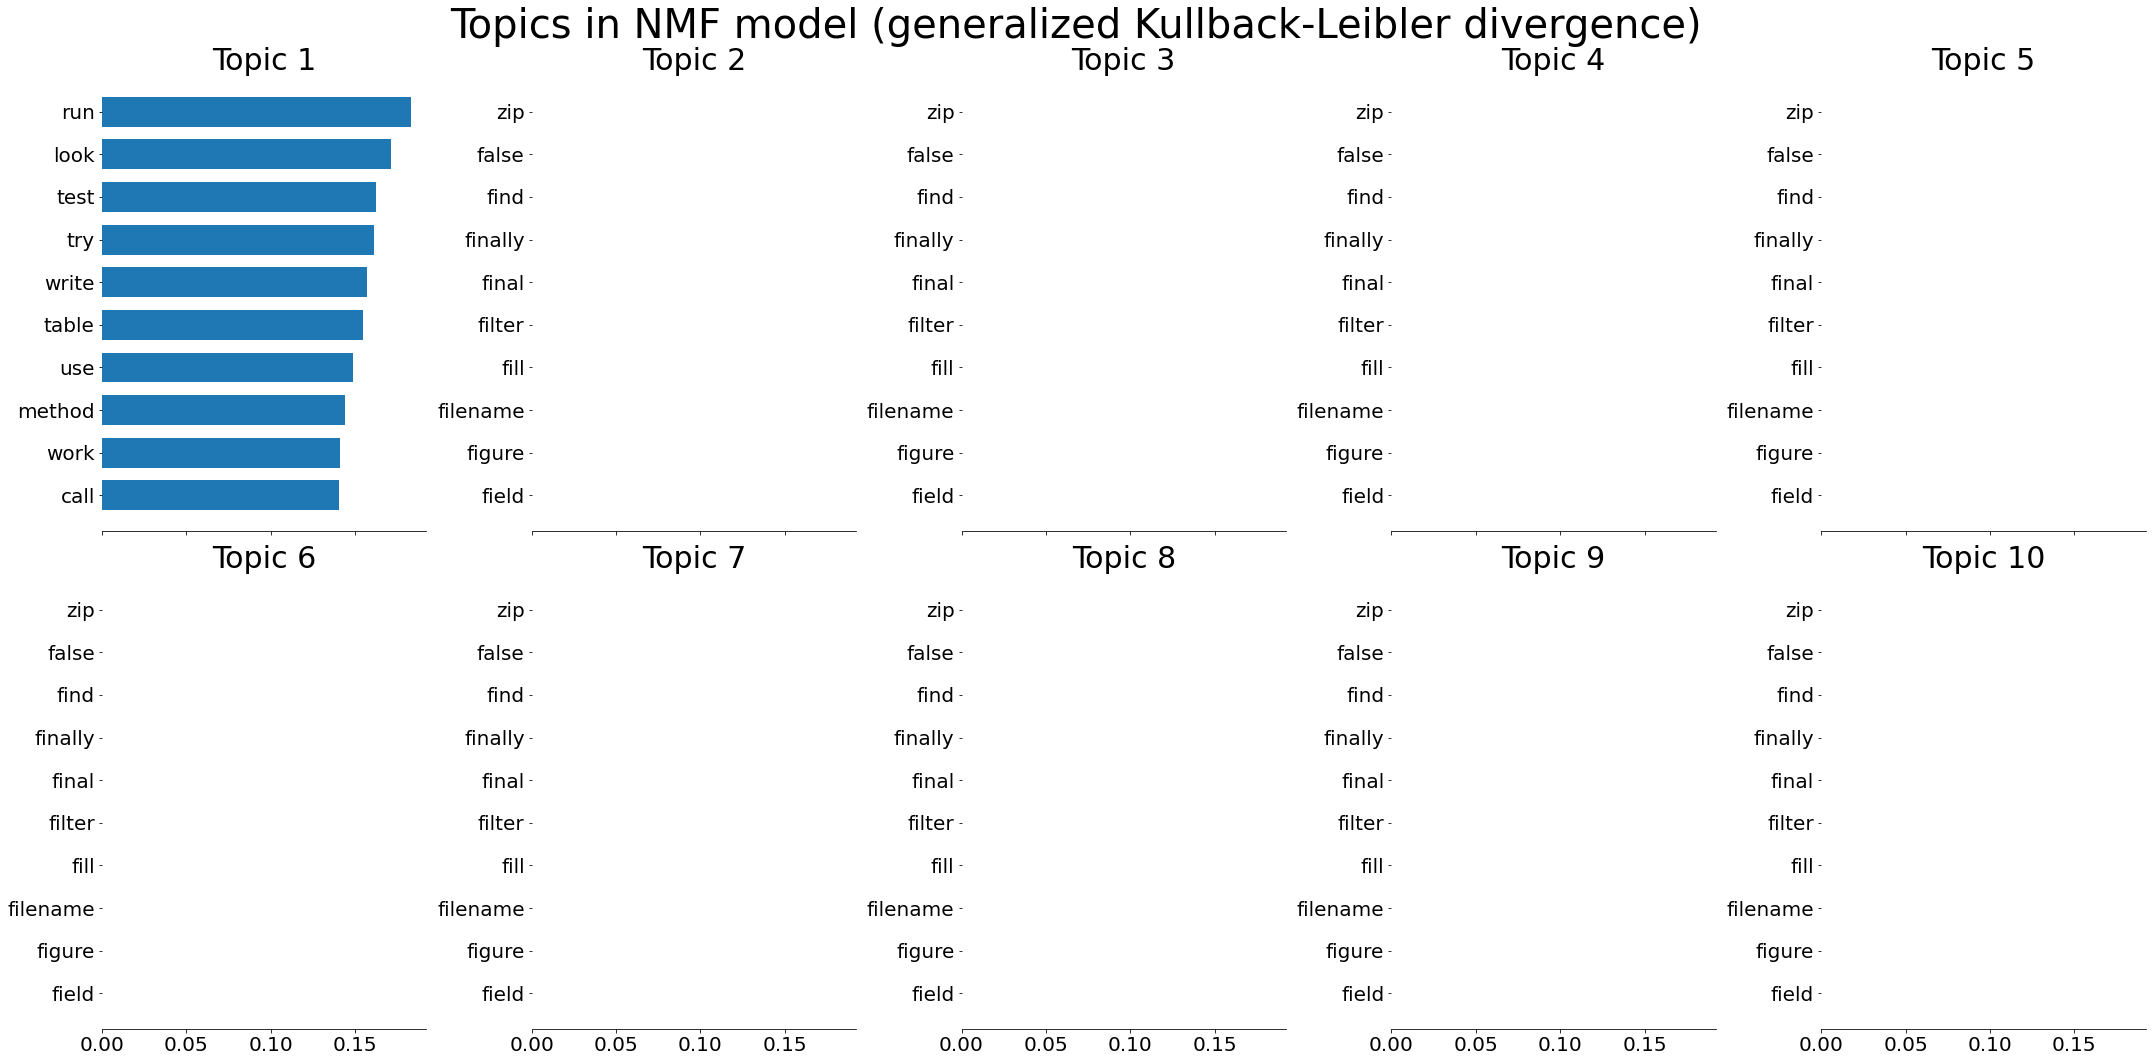

In [382]:
# Fit the NMF model with KL divergence
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time.time()
nmf = NMF(
    n_components=n_components,init = "nndsvda",
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.1, alpha_H="same",
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 6.842s.


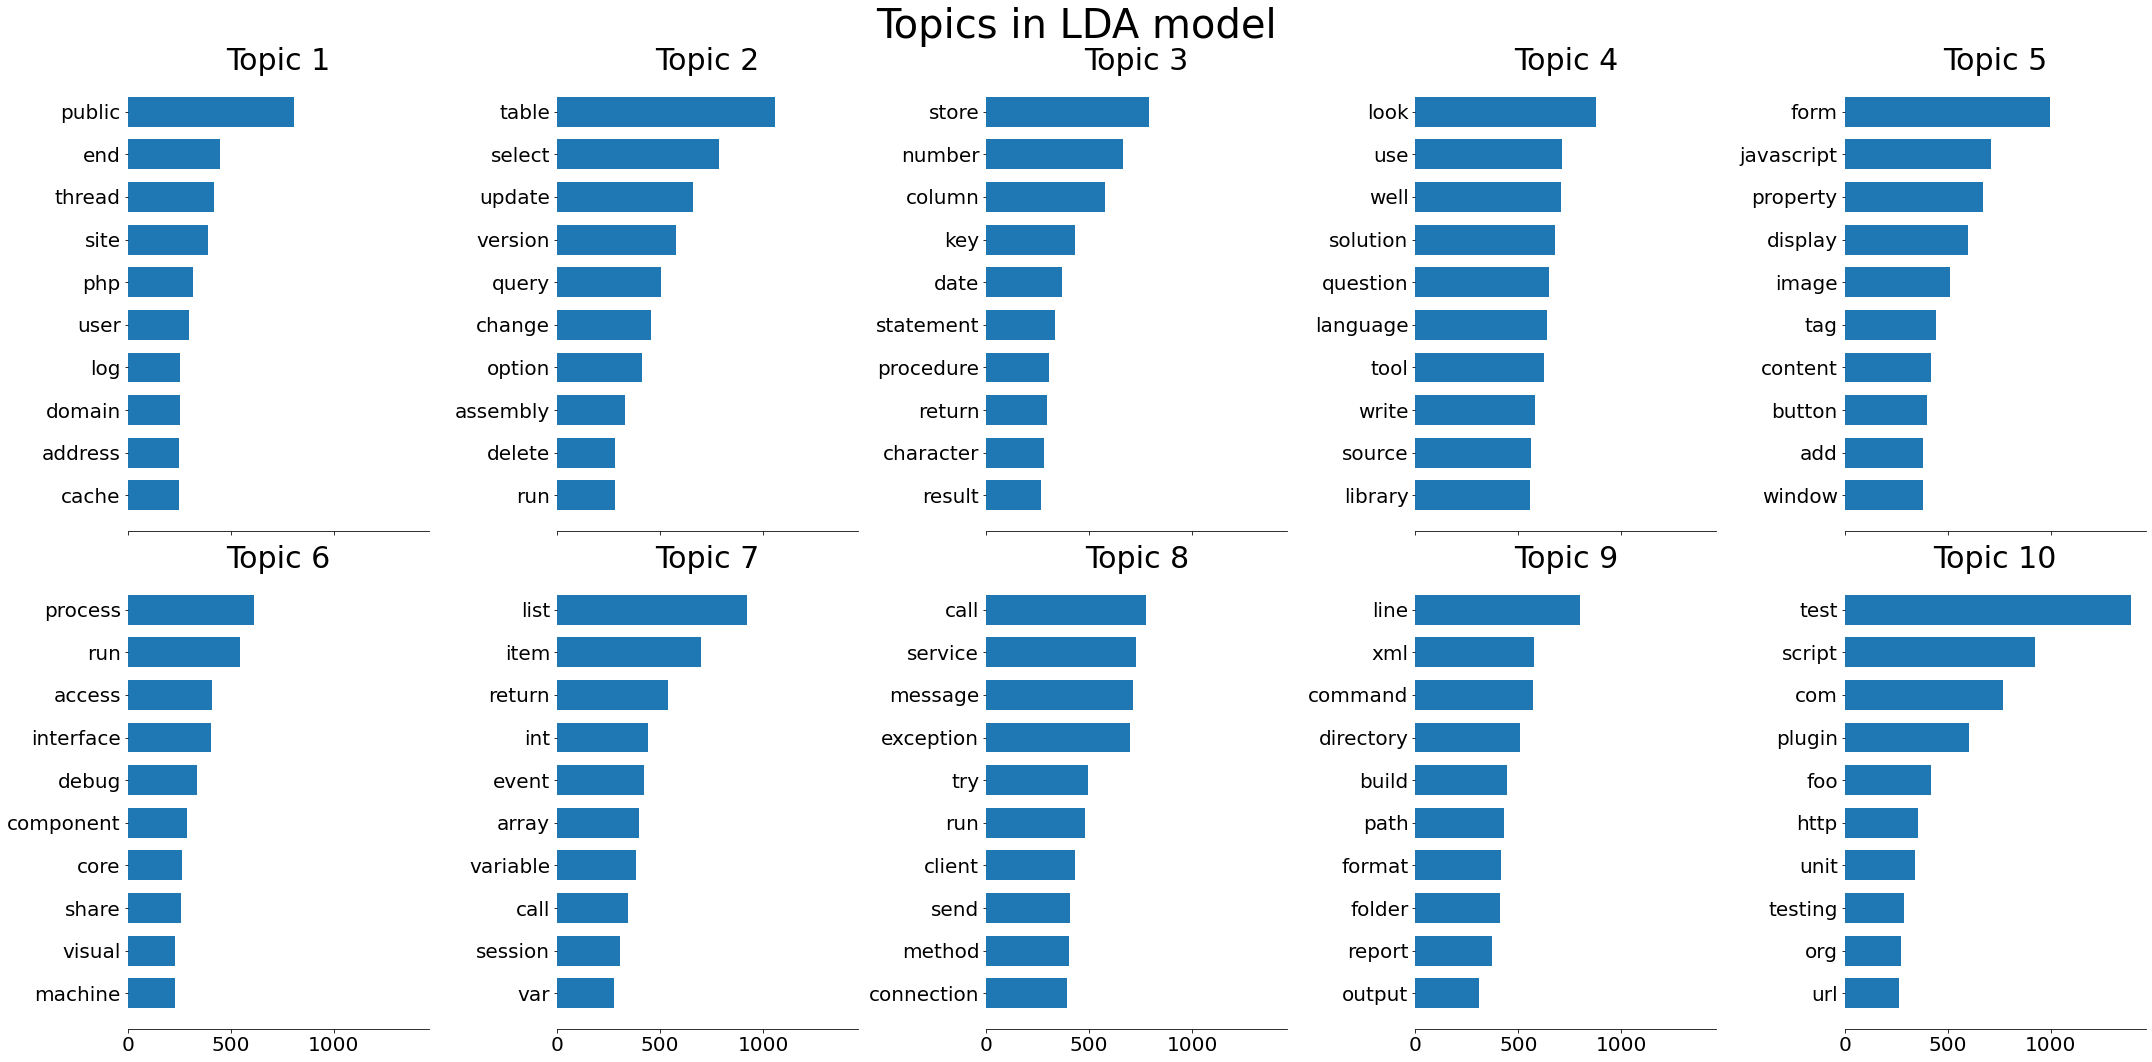

In [383]:
## LDA : 
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components, 
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time.time()
lda.fit(tf)
print("done in %0.3fs." % (time.time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


<a id ="section2.3"></a>
[back to menu](#menu)

## 2.C Optimisation des hyper-paramètres du LDA :
Je reviens au LDA, pour laquelle il faut fixer les "bons" choix de paramètres. Une validation croisée s'impose alors. Je construit un pipe python :
* La vectorisation a déjà été faite, je garde toutes les features quitte à ajouter une pénalisation lasso
* La LDA a différents paramètres à fixer : 
    * n_components = Number of topics.
    * max_iter=5 : The maximum number of passes over the training data (aka epochs)
    * learning_decay = 0.7 -> (0.5, 1.0] : It is a parameter that control learning rate in the online learning method.
    * learning_offset=50.0, : A (positive) parameter that downweights early iterations in online learning
* Le score proposé pour la LDA dans sklarn est la log-vraissemblance approchée. Cependant, vu que le lien texte/tag n'est pas encore traité, cela n'aura pas tant de sens de comparer à une sortie. Il sera plus intéressant de regarder la perplexité (aussi donnée dans la LDA de sklearn) Cependant, il y a l'air d'y avoir un [bug dans l'implémentation de la perplexité](https://github.com/scikit-learn/scikit-learn/issues/6777) dans sklearn.

In [354]:
def pseudo_cv_X_sparse(X_,  my_meth, param_grid, my_score, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    n_fold = 0 # just for print purpose 
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = cv)
    y=None
    CV_split_iterator = kf.split(X_,y) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        n_fold += 1 
        print("Fold "+str(n_fold))
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## extract test : 
        test_index = X_.index[CV_test_range_index]
        test = X_.iloc[CV_test_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            print(kwargs)
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            my_meth.fit(train)
            W = my_meth.transform(test)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(test, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)     
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

In [355]:
n_features = 1000
n_components = 10
## for print :
n_top_words = 20

In [356]:
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

param_grid = {"n_components" : [100,500,1000,2000,5000],
              "max_iter" : [5,10,20],
              "learning_decay" : [0.7,0.8,0.9] ,
              "learning_offset" : [50,100]}

my_score = sklearn.metrics.mean_squared_error
my_meth = LatentDirichletAllocation(n_jobs = 8, verbose = 0)

In [357]:
# res = pseudo_cv_X_sparse(X_train,  my_meth, param_grid, my_score, cv = 3)
# with open(res_path+"CV_LDA"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

In [358]:
with open(res_path+"CV_LDA"+".pkl", "rb") as f :
    res = pickle.load(f)
    
res = pd.concat((pd.DataFrame(res),pd.DataFrame(res['params'])), axis =1).drop("params", axis = 1)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,learning_decay,learning_offset,max_iter,n_components
0,4.168731,0.149787,0.046809,0.010979,45.688182,3.126705,0.7,50,5,100
1,7.600038,0.155918,0.058032,0.001381,10.635897,0.775504,0.7,50,5,500
2,14.707907,0.308149,0.076188,0.000659,6.508801,0.389180,0.7,50,5,1000
3,31.159872,1.902996,0.093726,0.009108,6.164688,0.096567,0.7,50,5,2000
4,85.902485,2.272121,0.143181,0.009320,22.692521,1.964681,0.7,50,5,5000


Exploration des différents résultats : 

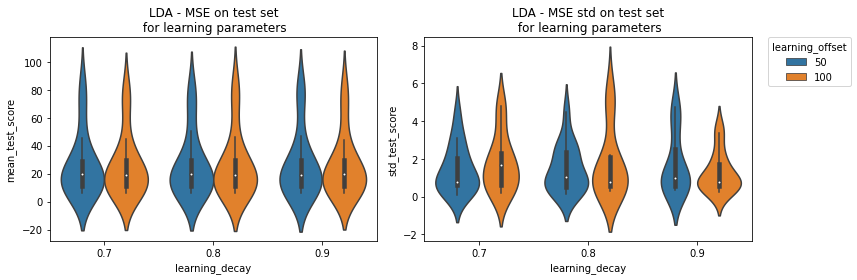

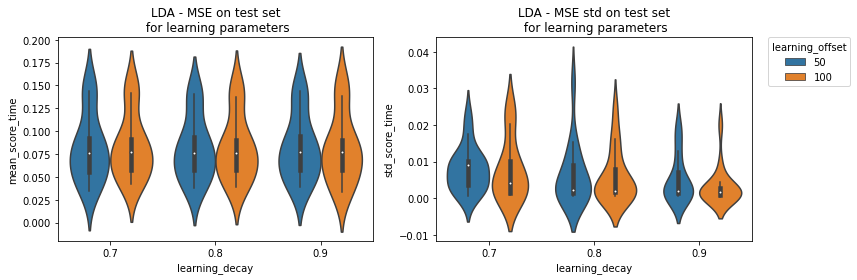

In [61]:
# MSE = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

## time = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

Les paramètres d'apprentissage n'ont pas d'impact sur le MSE, mais sur la robustesse des résultats (sur l'écart type des prédictions). Je garderai les paramètres qui donnent l'écart-type le plus petit.

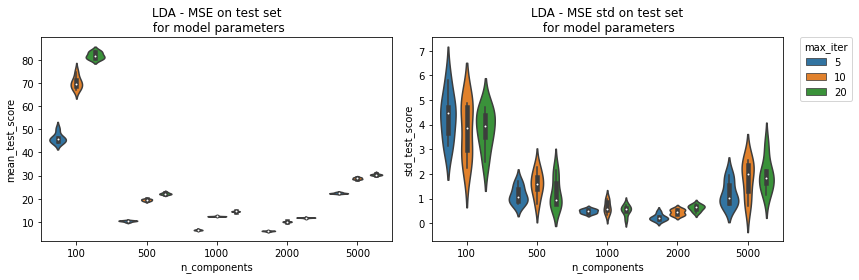

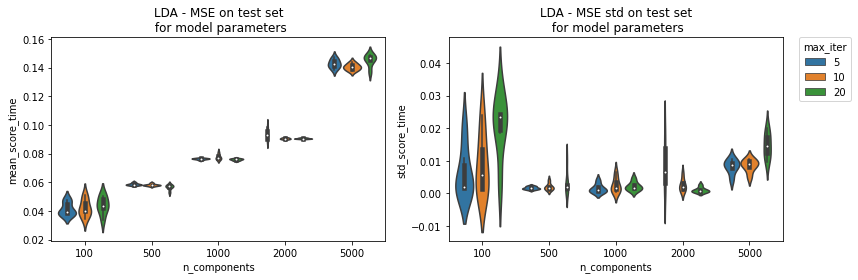

In [65]:
# MSE = f(n_components, max_iter)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_test_score",x = "n_components",hue = "max_iter", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for model parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_test_score",x = "n_components",hue = "max_iter", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "max_iter")
plt.title("LDA - MSE std on test set\n for model parameters")

plt.tight_layout()
plt.show()

## time = f(n_components, max_iter)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_score_time",x = "n_components",hue = "max_iter", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for model parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_score_time",x = "n_components",hue = "max_iter", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "max_iter")
plt.title("LDA - MSE std on test set\n for model parameters")

plt.tight_layout()
plt.show()

La LDA donne de meilleurs résultats pour 1000 et 2000 composantes, au delà, le MSE augmente, ainsi que le temps de calcul. Le MSE est minimal pour 5 itérations maximales. 

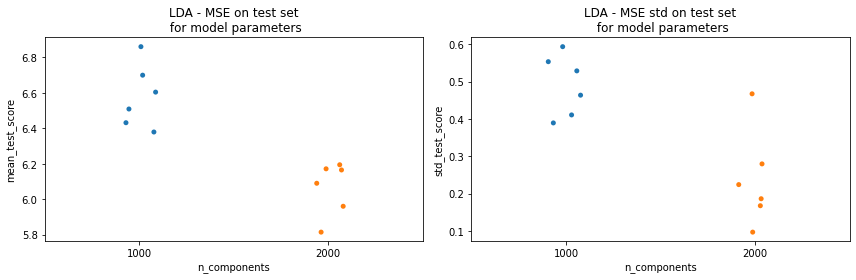

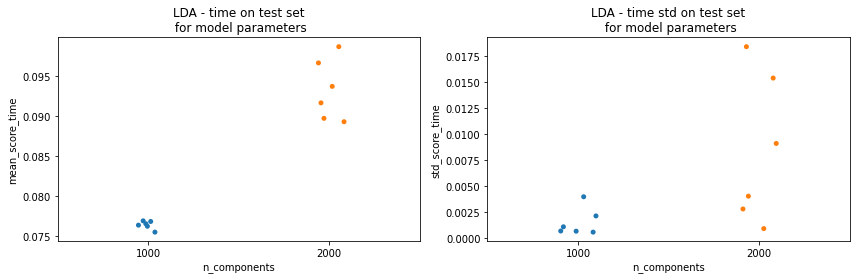

In [109]:
res2 = res[res.max_iter == 5]
res2 = res2[res2.n_components.isin([1000,2000])]
res2 = res2.astype({"n_components":"category"})

# MSE = f(n_components, max_iter)
fig, axs = plt.subplots (1, 2, figsize=(12,4))

axs[0].set_title("LDA - MSE on test set\n for model parameters")
sns.stripplot(x = "n_components", y="mean_test_score", data=res2, ax=axs[0])

axs[1].set_title("LDA - MSE std on test set\n for model parameters")
sns.stripplot(x = "n_components", y="std_test_score", data=res2, ax=axs[1])

plt.tight_layout()
plt.show()


## time = f(n_components, max_iter)
fig, axs = plt.subplots (1, 2, figsize=(12,4))

axs[0].set_title("LDA - time on test set\n for model parameters")
sns.stripplot(x = "n_components", y="mean_score_time", data=res2, ax=axs[0])

axs[1].set_title("LDA - time std on test set\n for model parameters")
sns.stripplot(x = "n_components", y="std_score_time", data=res2, ax=axs[1])

plt.tight_layout()
plt.show()

Les prédictions sont légèrement meilleures avec 2000 composantes. Les paramètres d'apprentissage n'influançant que peu, je vais les fixer à learning_rate = 0.9 et learning_offset = 100 

In [359]:
## best params : 
best_params = {
    "learning_decay" : 0.9,
    "learning_offset" : 100,
    "n_components" : 2000,
    "max_iter" : 5,
}

t0 = time.time()
lda_model = LatentDirichletAllocation(n_jobs = 8, verbose = 0, **best_params)
lda_model.fit(X_train)
print("done in %0.3fs." % (time.time() - t0))

done in 34.542s.


Pour évaluer cette partie, je me suis beaucoup inspirée de [ce travail](https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6)

In [267]:
print("Log Likelihood: ", lda_model.score(X_train))
## be caution : an error in sklearn mentionned above
print("Perplexity: ", lda_model.perplexity(X_train))

Log Likelihood:  -2030032.699167025
Perplexity:  3875.9419849702513


In [273]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(X_train)# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]# index names
docnames = ["Doc" + str(i) for i in range(X_train.shape[0])]# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic# Styling
def color_green(val):
    color = "green" if val > .1 else "black"
    return "color: {col}".format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return "font-weight: {weight}".format(weight=weight)# Apply Style
# df_document_topics_h = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
# df_document_topics_h

In [277]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)# Assign Column and Index
df_topic_keywords.columns = countvec.get_feature_names_out()
df_topic_keywords.index = topicnames# View
df_topic_keywords.head()

,ability,able,abstract,accept,access,accomplish,accord,account,achieve,action,...,worth,wpf,wrap,write,writing,wrong,www,xml,year,zip
Topic0,0.0005,3.574938,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,1.050323,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic1,0.0005,1.352624,0.0005,0.0005,0.000500,0.026936,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic2,0.0005,0.000500,0.0005,0.0005,0.916566,0.000500,0.0005,0.0005,0.0005,0.617561,...,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic3,0.0005,0.000500,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005
Topic4,0.0005,0.000500,0.0005,0.0005,0.000500,0.000500,0.0005,0.0005,0.0005,0.000500,...,0.0005,0.0005,0.000500,7.212528,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005


In [283]:
## get the 10 most important word in each topic :
# Show top n keywords for each topic
def show_topics(vectorizer=countvec, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=countvec, lda_model=lda_model, n_words=10)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,exception,handler,happen,handle,far,possible,event,run,able,message
Topic 1,tree,look,use,structure,need,solve,require,provide,represent,include
Topic 2,delete,publish,say,run,sure,right,make,change,require,really
Topic 3,ability,practice,pre,prefer,preferably,present,press,pretty,prevent,previous
Topic 4,miss,really,try,say,feature,actually,require,write,think,come
...,...,...,...,...,...,...,...,...,...,...
Topic 1995,win,run,different,currently,hardware,unique,write,happen,result,version
Topic 1996,appear,constraint,ui,ability,pre,prefer,preferably,present,press,pretty
Topic 1997,ability,practice,pre,prefer,preferably,present,press,pretty,prevent,previous
Topic 1998,wrong,sure,fine,trigger,actually,idea,think,work,try,start


Et en reprenant les représentations des mots prépondérants par topic comme proposé dans [sklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

In [319]:
def plot_top_words_5(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30,10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:5]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
#         ax.set_xlim((.9*min(weights),1.1*max(weights)))
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

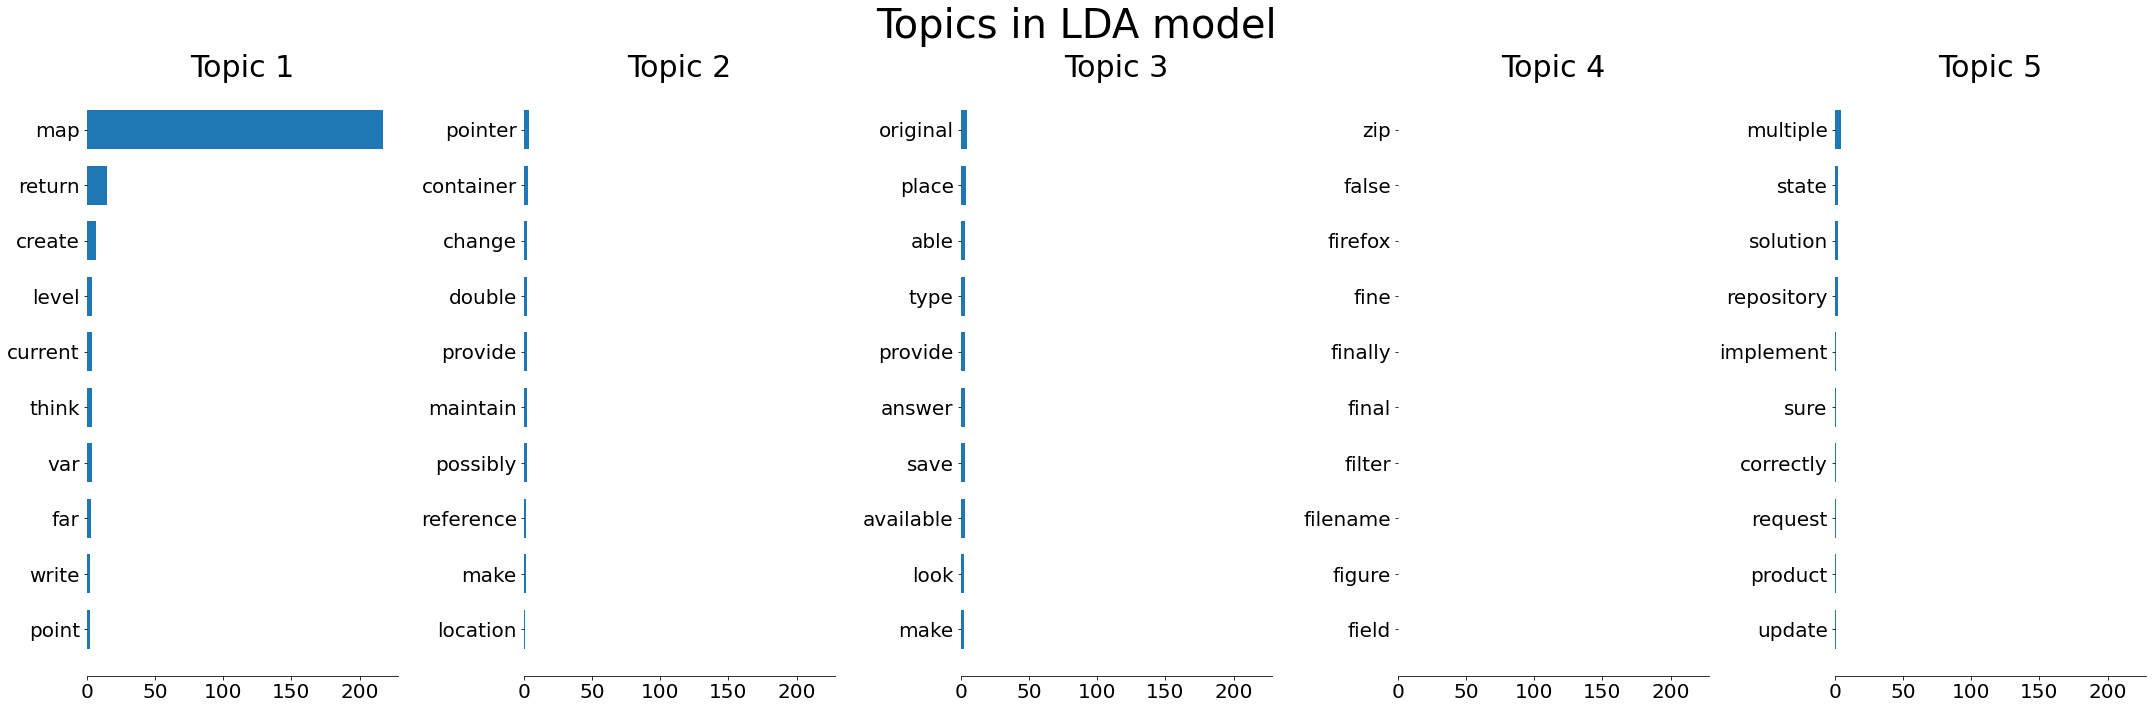

In [320]:
tf_feature_names = countvec.get_feature_names_out()
n_top_words = 10
plot_top_words_5(lda, tf_feature_names, n_top_words, "Topics in LDA model")

Bien que les données soient statistiquement mieux résumées avec 2000 composantes, il y en a trop pour pouvoir les traiter rapidement (comme en donnant un label à chaque classe). Je relance la LDA avec moins de classe pour présenter la démarche en gagnant du temps. 

In [284]:
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

param_grid = {"n_components" : [20],
              "max_iter" : [5,10,20],
              "learning_decay" : [0.7,0.8,0.9] ,
              "learning_offset" : [50,100]}

my_score = sklearn.metrics.mean_squared_error
my_meth = LatentDirichletAllocation(n_jobs = 8, verbose = 0)

In [288]:
# res = pseudo_cv_X_sparse(X_train,  my_meth, param_grid, my_score, cv = 3)
# with open(res_path+"CV_LDA_small"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"CV_LDA_small"+".pkl", "rb") as f :
    res = pickle.load(f)
    
res = pd.concat((pd.DataFrame(res),pd.DataFrame(res['params'])), axis =1).drop("params", axis = 1)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,learning_decay,learning_offset,max_iter,n_components
0,3.871092,0.075068,0.037246,0.003751,458.594154,39.395223,0.7,50,5,20
1,5.471821,0.441186,0.037739,0.004562,663.495223,64.601442,0.7,50,10,20
2,8.896921,0.383469,0.031421,0.006669,681.505430,33.858481,0.7,50,20,20
3,3.988453,0.199684,0.033575,0.002652,487.705142,37.189865,0.7,100,5,20
4,5.705815,0.271925,0.031955,0.004583,622.067470,68.314112,0.7,100,10,20


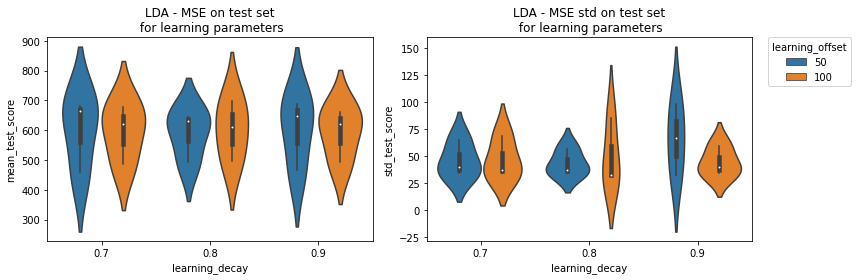

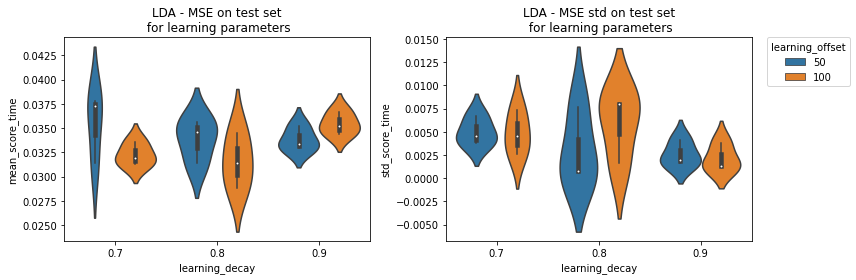

In [289]:
# MSE = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_test_score",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

## time = f(learning_decay, learning_offset)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.violinplot(y="mean_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend("",frameon=False)
plt.title("LDA - MSE on test set\n for learning parameters")

plt.subplot(1,2,2)
sns.violinplot(y="std_score_time",x = "learning_decay",hue = "learning_offset", data=res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= "learning_offset")
plt.title("LDA - MSE std on test set\n for learning parameters")

plt.tight_layout()
plt.show()

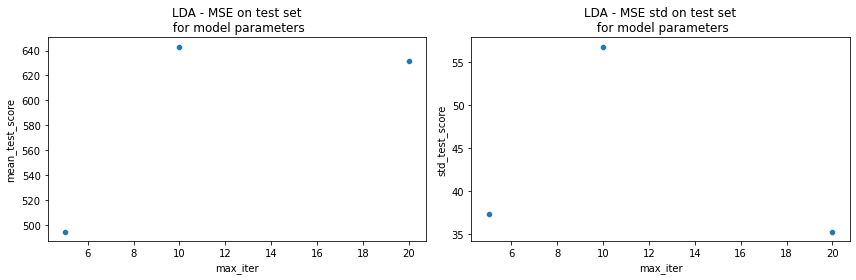

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,learning_decay,learning_offset,max_iter,n_components
6,4.023021,0.163657,0.034588,0.000708,494.783426,37.360740,0.8,50,5,20
7,5.666318,0.158409,0.031374,0.007694,643.108002,56.835022,0.8,50,10,20
8,9.027814,0.319854,0.035610,0.000731,631.731069,35.254802,0.8,50,20,20


In [301]:
res2 = res[res.learning_offset == 50]
res2 = res2[res2.learning_decay == 0.8]

# MSE = f(n_components, max_iter)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("LDA - MSE on test set\n for model parameters")
sns.scatterplot(x = "max_iter", y="mean_test_score", data=res2)
plt.subplot(1,2,2)
plt.title("LDA - MSE std on test set\n for model parameters")
sns.scatterplot(x = "max_iter", y="std_test_score", data=res2)

plt.tight_layout()
plt.show()
res2

In [482]:
## best params : 
best_params_small = { "learning_decay" : 0.8, "learning_offset" : 50,
                "n_components" : 20, "max_iter" : 5 }

t0 = time.time()
lda_model_small = LatentDirichletAllocation(n_jobs = 8, verbose = 0, **best_params_small)
lda_model_small.fit(X_train)
print("done in %0.3fs." % (time.time() - t0))

done in 3.924s.


In [483]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model_small.components_)# Assign Column and Index
df_topic_keywords.columns = countvec.get_feature_names_out()
df_topic_keywords.index = ["Topic" + str(i) for i in range(lda_model_small.n_components)]# index names

df_topic_keywords

,ability,able,abstract,accept,access,accomplish,accord,account,achieve,action,...,worth,wpf,wrap,write,writing,wrong,www,xml,year,zip
Topic0,0.051257,24.707394,2.610111,6.731084,14.756567,2.140143,0.050000,0.050000,1.525687,53.546855,...,0.080788,6.545339,10.537252,68.265272,14.104732,19.204503,2.178842,0.442891,0.052008,0.050000
Topic1,7.616361,60.825750,0.050000,3.161056,58.435715,13.033824,5.765193,4.356956,20.935395,12.235592,...,0.051484,0.062117,1.982308,172.938919,21.366131,5.707055,0.050781,0.308819,1.787154,0.050000
Topic2,0.050000,38.295732,0.050100,0.064391,53.393773,0.222218,0.326872,0.050000,3.217974,2.241918,...,3.675787,0.112915,0.424091,53.610421,2.707344,10.477160,0.050019,19.128407,30.492525,0.050001
Topic3,0.050000,56.522193,0.050000,22.311618,6.664561,9.273159,9.246406,1.021077,11.804931,0.050000,...,0.050010,0.366653,9.205319,48.685728,9.521520,12.034039,0.155545,0.392659,13.306362,5.031130
Topic4,7.259954,47.439803,0.050000,11.441812,123.897063,13.296395,2.657106,18.181356,1.037200,10.871782,...,3.750270,0.079331,1.071761,149.984835,4.649176,7.740075,0.535555,7.387340,30.081772,0.050000
Topic5,1.005718,18.121758,0.234203,13.384665,53.963382,3.858699,2.526691,11.070895,3.750601,103.042267,...,0.421227,0.050000,0.389152,36.347556,1.358943,10.944707,10.449828,1.972516,0.116268,64.573512
Topic6,6.909663,50.161188,0.050000,51.632749,70.380199,3.217843,1.352665,94.493107,3.517345,13.236822,...,21.691996,0.050007,0.483272,95.914315,12.007646,5.457586,112.935844,0.097387,30.837713,0.050000
Topic7,0.050069,40.276858,0.050000,0.466251,23.131181,11.433714,0.050174,0.129555,1.013384,1.887555,...,0.050000,21.293172,11.994398,83.730857,3.527803,23.549354,56.281041,641.108623,9.510577,0.050000
Topic8,1.378421,78.564387,0.050000,4.864655,18.681033,1.878736,0.242803,11.104289,2.000509,4.091355,...,9.232397,15.884767,1.576325,106.475737,5.702163,4.410517,0.698602,2.524534,9.742278,0.052625
Topic9,27.060182,67.093890,2.366535,10.586028,68.420860,0.050000,2.561013,0.478512,0.050000,2.150217,...,10.376109,0.050000,1.980197,83.783959,17.509029,2.266922,0.050000,0.069251,29.999426,0.050000


In [484]:
topic_keywords = show_topics(vectorizer=countvec, lda_model=lda_model_small, n_words=10)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,form,button,interface,window,method,return,control,parameter,javascript,component
Topic 1,process,thread,run,memory,task,update,write,event,video,start
Topic 2,table,column,store,row,query,tag,procedure,view,update,select
Topic 3,line,command,output,print,bit,array,paradigmplus,program,size,question
Topic 4,language,program,write,dialog,page,user,access,question,route,array
Topic 5,directory,session,site,org,cache,log,download,script,svn,apache
Topic 6,com,client,connection,send,php,email,url,http,request,connect
Topic 7,xml,template,expression,replace,match,map,character,parse,regex,com
Topic 8,test,build,script,tool,run,javascript,app,automate,testing,service
Topic 9,look,use,tool,performance,linux,start,library,work,edit,platform


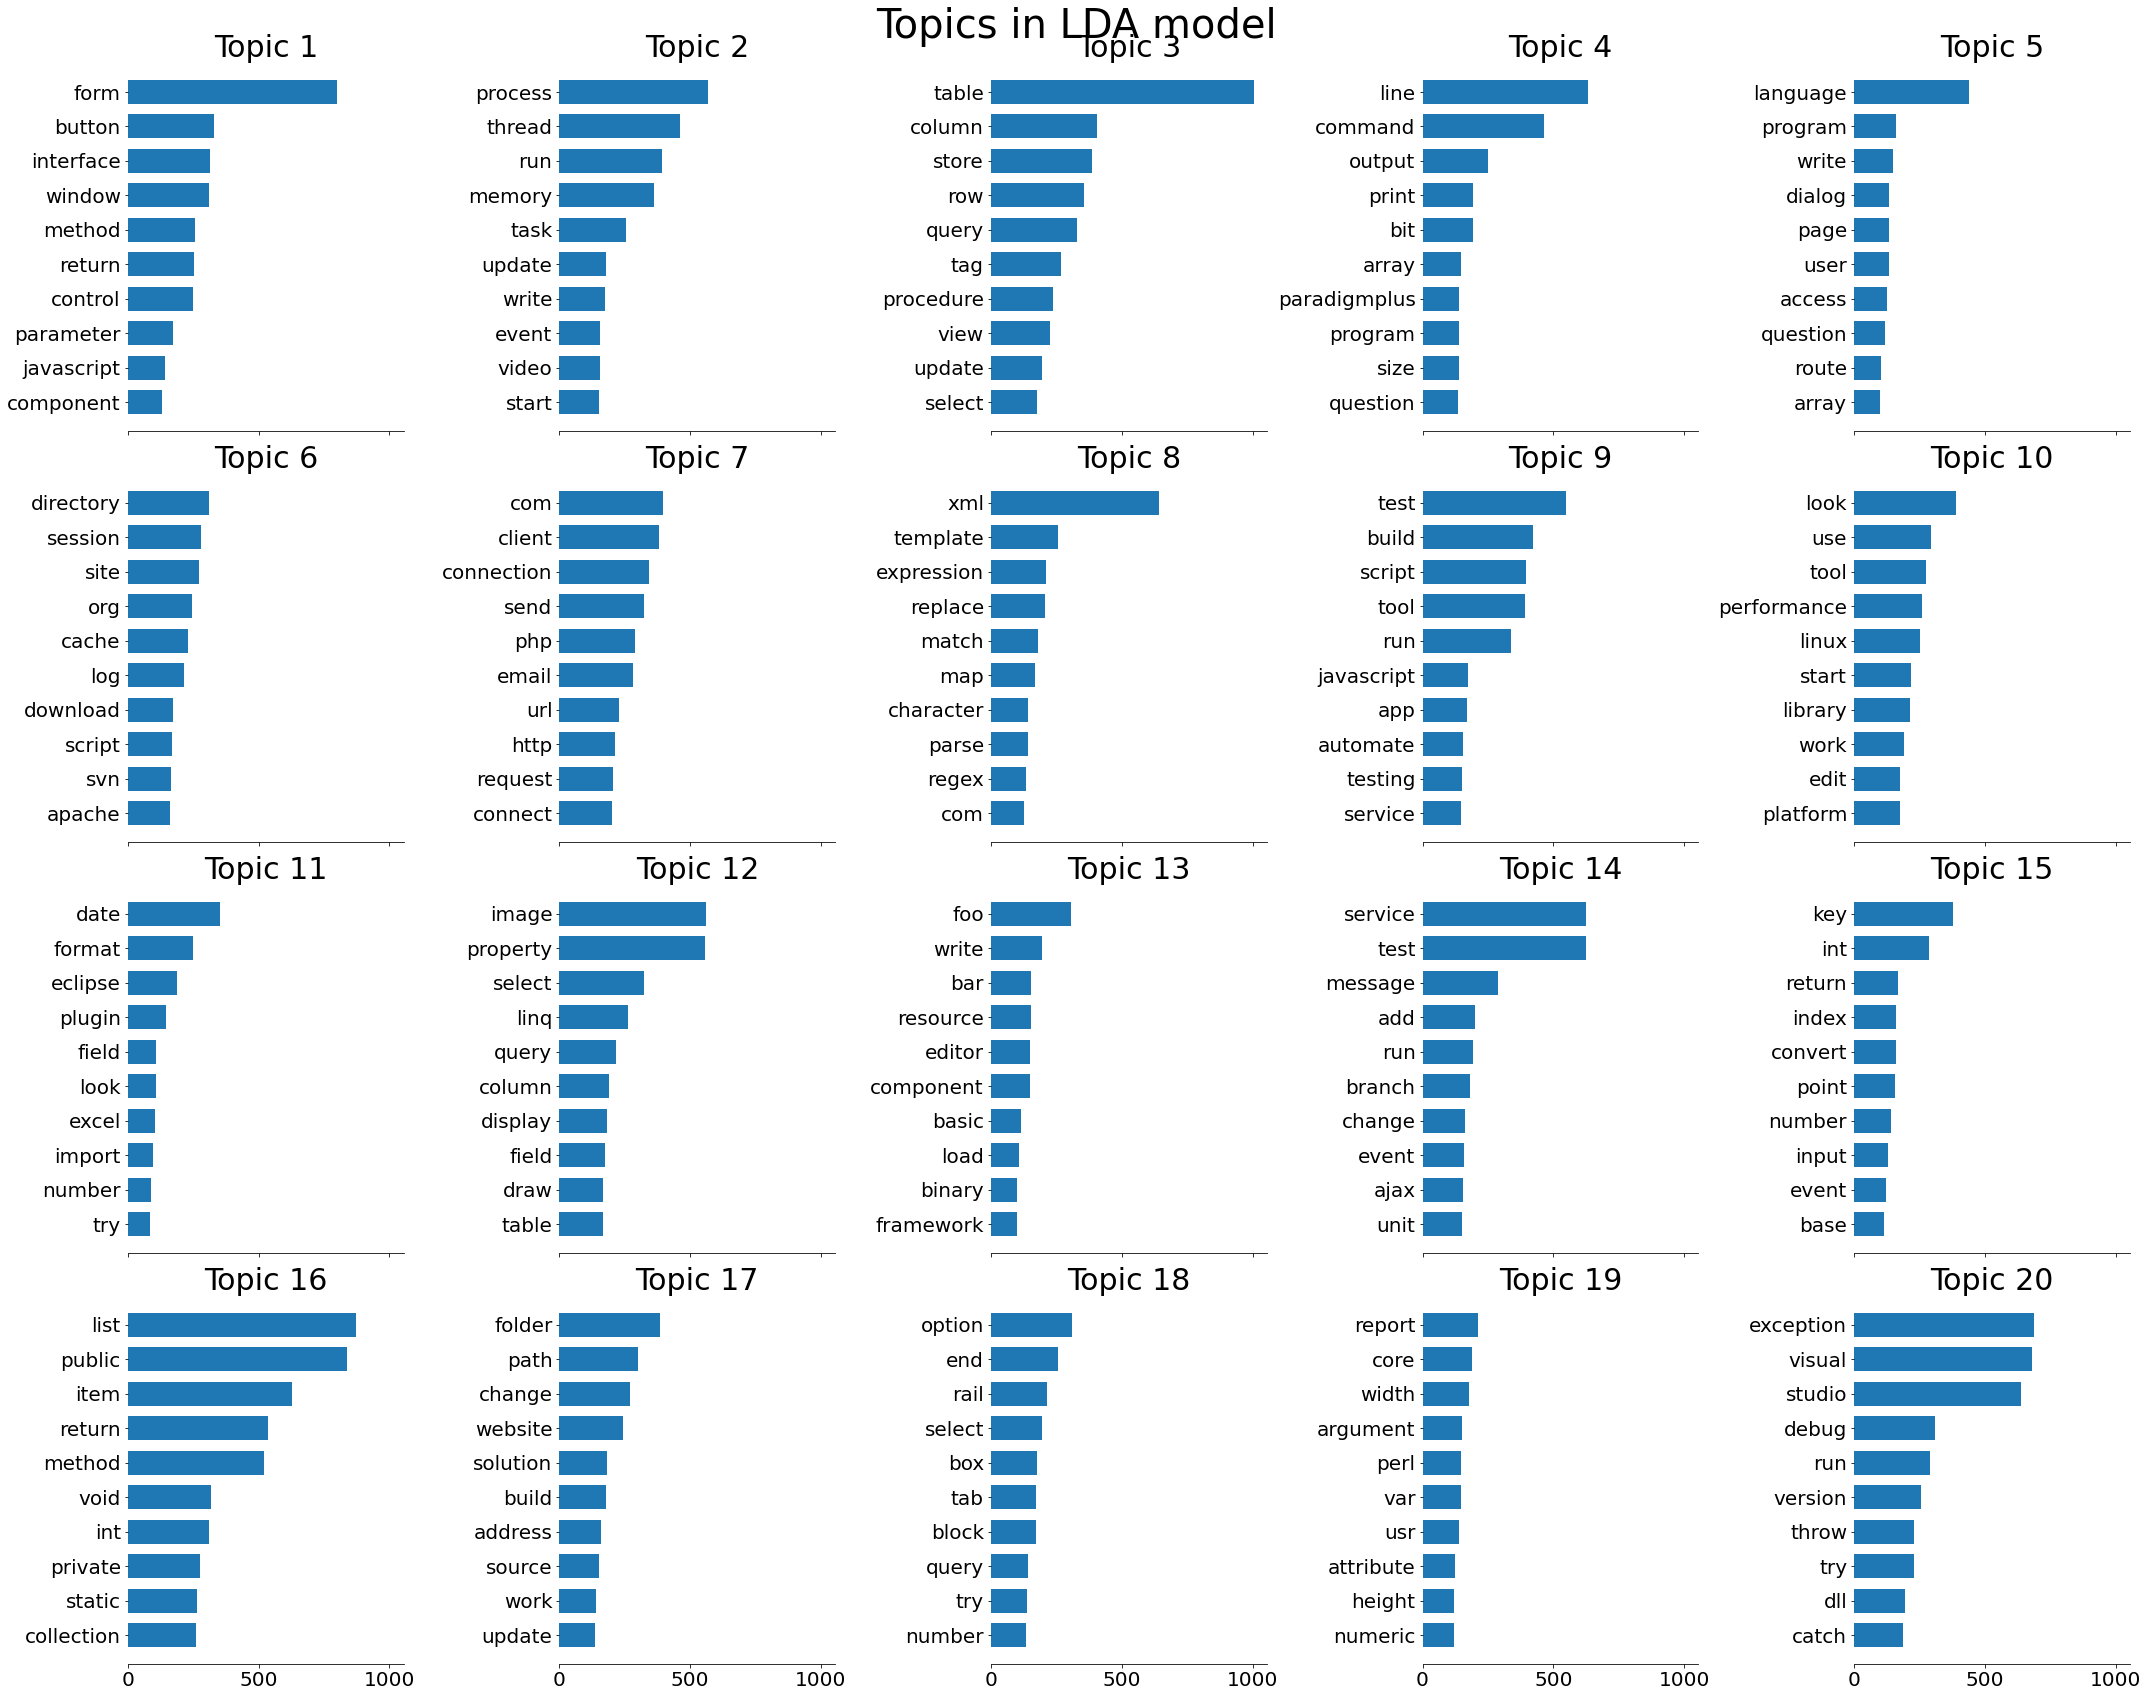

In [485]:
tf_feature_names = countvec.get_feature_names_out()
n_top_words = 10
plot_top_words(lda_model_small, tf_feature_names, n_top_words, "Topics in LDA model", n5 = 4,)

De ces listes, on peut extraire un topic général comme "UI" pour le topic 1, ou "manipulation_table" pour le topic 3.

<a id ="section2.4"></a>
[back to menu](#menu)

## 2.D LDA - modèle sur test :
Limitons cette exploration aux deux topics identifiés comme "UI" (topic_1) "manipulation_table" (topic_3) 

In [487]:
X_pred = lda_model_small.transform(X_test)

In [550]:
pred_1 = pd.Series(X_pred[:,0], index=test_index, name = "UI")
pred_3 = pd.Series(X_pred[:,2], index=test_index, name = "manipulation_table")
pred_4 = pd.Series(X_pred[:,3], index=test_index, name = "unix")
## get predicted as topic 1 or 3 posts :
UI_posts_index = pred_1[pred_1>0.9].index
manipulation_table_posts_index = pred_3[pred_3>0.94].index
unix_index = pred_4[pred_4>0.9].index

## other topic removed :
pred_2 = pd.Series(X_pred[:,1], index=test_index, name = "topic2")
pred_5 = pd.Series(X_pred[:,4], index=test_index, name = "topic5")
pred_6 = pd.Series(X_pred[:,5], index=test_index, name = "topic6")
index_2 = pred_2[pred_2>0.9].index
index_5 = pred_5[pred_5>0.9].index
index_6 = pred_6[pred_6>0.9].index

Les posts taggués comme "manipulation_table_posts_index", et les tags associés au postes sont les suivants

In [551]:
for k in manipulation_table_posts_index :
    tags = df_tags.loc[k,:]
    tags = list(tags[tags>0].index)
    print("tags = ", tags)
    print("text = ", save_corpora[k])
    print()

tags =  ['puzzle']
text =  what is the simplest sql query to find the second largest value what is the simplest sql query to find the second largest integer value in a specific column there are maybe duplicate values in the column

tags =  ['stored-procedures']
text =  how do i determine using tsql what roles are granted execute permissions on a specific stored procedure how do i determine using tsql what roles are granted execute permissions on a specific stored procedure is there a system stored procedure or a system view i can use

tags =  []
text =  sql select columns with null values only how do i select all the columns in a table that only contain null values for all the rows i m using ms sql server i m trying to find out which columns are not used in the table so i can delete them

tags =  ['boolean', 'database', 'ms-access', 'null', 'odbc']
text =  how do you deal with null values in columns of type boolean in ms access i was wondering if there is a better way to cope with ms a

Pour les posts "unix" :

In [552]:
for k in unix_index:
    tags = df_tags.loc[k,:]
    tags = list(tags[tags>0].index)
    print("tags = ", tags)
    print("text = ", save_corpora[k])
    print()

tags =  ['language-agnostic']
text =  how can i reverse the on bits in a byte i was reading joel s book where he was suggesting as interview question write a program to reverse the on bits in a given byte i only can think of a solution using c asking here so you can show me how to do in a non c way if possible

tags =  ['dos2unix', 'editor', 'file', 'linux', 'vim']
text =  convert dos line endings to linux line endings in vim if i open files i created in windows the lines all end with m how do i delete these characters all at once

tags =  ['command', 'powershell', 'unix']
text =  equivalent of nix which command in powershell how do i ask powershell where something is for instance which notepad and it returns the directory where the notepad exe is run from according to the current paths



Cependant, la class "UI" ne semble pas bien juste :

In [553]:
for k in UI_posts_index :
    tags = df_tags.loc[k,:]
    tags = list(tags[tags>0].index)
    print("tags = ", tags)
    print("text = ", save_corpora[k])
    print()

tags =  ['form-submit', 'forms', 'html', 'submit-button']
text =  multiple submit buttons in an html form let s say you create a wizard in an html form one button goes back and one goes forward since the back button appears first in the markup when you press enter it will use that button to submit the form example form put your cursor in this field and press enter input type text name field this is the button that will submit input type submit name prev value previous page but this is the button that i want to submit input type submit name next value next page form i would like to get to decide which button is used to submit the form when a user presses enter that way when you press enter the wizard will move to the next page not the previous do you have to use tabindex to do this

tags =  ['asp.net', 'javascript', 'onclick', 'csharp']
text =  call asp net function from javascript i m writing a web page in asp net i have some javascript code and i have a submit button with a click even

<a id ="section2.3"></a>
[back to menu](#menu)

## 2.C LDA avec pyLDAviz
[Une bibliothèque](https://pyldavis.readthedocs.io/en/latest/readme.html) propose des visualisations de la LDA pour interpréter les résultats facilement, dont un notebook d'illustration est proposé [ici](https://nbviewer.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN%20Topic%20Model%20Talk.ipynb)

https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

In [168]:
from __future__ import division

# import graphlab as gl
# import pandas as pd
import pyLDAvis

In [153]:
# Build data for LDA model
tokens = [t.split(' ') for t in corpora.values()]
id2word = Dictionary(tokens)
corpus = [id2word.doc2bow(text) for text in tokens]
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

[[('bar', 1),
  ('build', 1),
  ('change', 1),
  ('convert', 2),
  ('decimal', 3),
  ('double', 3),
  ('fine', 1),
  ('follow', 1),
  ('form', 1),
  ('give', 1),
  ('implicitly', 1),
  ('opacity', 2),
  ('track', 1),
  ('trackbar', 1),
  ('tran', 2),
  ('try', 1),
  ('vb', 1),
  ('work', 1)]]

In [154]:
lda_model = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=10, 
               random_state=0,
               chunksize=100,
               alpha='auto',
               per_word_topics=True)
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [160]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3363646038255555


In [179]:
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models 
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
p

/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/hom

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.296786 -0.050298       1        1  34.010426
7      0.227684  0.088356       2        1  18.550329
0      0.217435 -0.049562       3        1  16.116194
9      0.141473 -0.053946       4        1  10.353326
2     -0.082261  0.319158       5        1   5.549551
5     -0.100126 -0.188575       6        1   4.784397
1     -0.131404  0.142812       7        1   3.490276
8     -0.184385 -0.084327       8        1   2.841431
4     -0.190542 -0.061647       9        1   2.414795
6     -0.194660 -0.061970      10        1   1.889275, topic_info=            Term         Freq        Total Category  logprob  loglift
162         test  2275.000000  2275.000000  Default  30.0000  30.0000
341         list  1369.000000  1369.000000  Default  29.0000  29.0000
489          com  1433.000000  1433.000000  Default  28.0000  28.0000
8           form  1162.000000  1162.000000  Default  27.0000  27.0000
252        event  1068.000000  1068.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
5023  relational    59.611239    60.577023  Topic10  -5.0494   3.9529
3921        init    58.726362    59.699971  Topic10  -5.0644   3.9525
657      connect   536.450466   547.168492  Topic10  -2.8523   3.9492
733          log   714.648662   731.485947  Topic10  -2.5655   3.9457
1032        word   276.574757   441.028582  Topic10  -3.5148   3.5023

[494 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
99        2  0.004937       _
99        6  0.993998       _
750       4  0.986101  accept
750       8  0.009796  accept
486       1  0.654337  access
...     ...       ...     ...
988       2  0.990673   wrong
988       7  0.008165   wrong
1870      5  0.996004     www
623       2  0.994149     xml
623       4  0.005364     xml

[834 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 1, 10, 3, 6, 2, 9, 5, 7])

In [180]:
pyLDAvis.save_html(p, res_path+'lda.html')

<a id ="section3"></a>
[back to menu](#menu)

# 3. Approche supervisée

<a id ="section3.1"></a>
[back to menu](#menu)

## 3.A Naive Bayes on uniclass :
#### Different models :

In [53]:
naive_bayes1 = BernoulliNB(alpha=0.1, binarize=0) 

## train : 
naive_bayes1.fit(X_train, y_train)

## test :
Y_pred = naive_bayes1.predict(X_test)
print("Mean accuracy with default params", 
      naive_bayes1.score(X_test,y_test),
      "on test set")

Mean accuracy with default params 0.8392213410237923 on test set


In [115]:
naive_bayes1 = BernoulliNB(alpha=0.1, binarize=1) 

## train : 
naive_bayes1.fit(X_train, y_train)

## test :
Y_pred = naive_bayes1.predict(X_test)
print("Accuracy with default params", 
       np.round(naive_bayes1.score(X_test,y_test),3),
      "on test set")

Accuracy with default params 0.86 on test set


In [116]:
naive_bayes2 = ComplementNB(alpha=50, norm=True) 

## train : 
naive_bayes2.fit(X_train, y_train)

## test :
y_pred = naive_bayes2.predict(X_test)
print("Accuracy with default params", 
      np.round(naive_bayes2.score(X_test,y_test),3),
      "on test set")

Accuracy with default params 0.855 on test set


In [117]:
naive_bayes3 = MultinomialNB(alpha=0.1) 

## train : 
naive_bayes3.fit(X_train, y_train)

## test :
y_pred = naive_bayes3.predict(X_test)
print("Accuracy with default params", 
      np.round(naive_bayes3.score(X_test, y_test),3),
      "on test set")

Accuracy with default params 0.826 on test set


#### Optimise classifier params : 

BernoulliNB


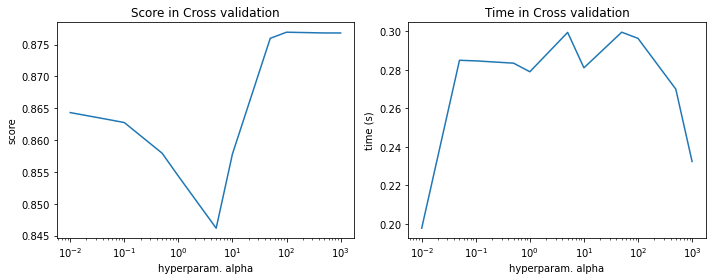

ComplementNB


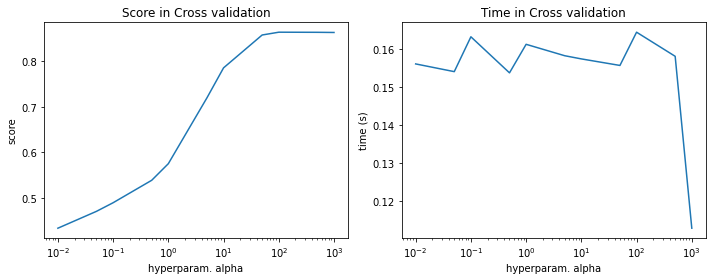

MultinomialNB


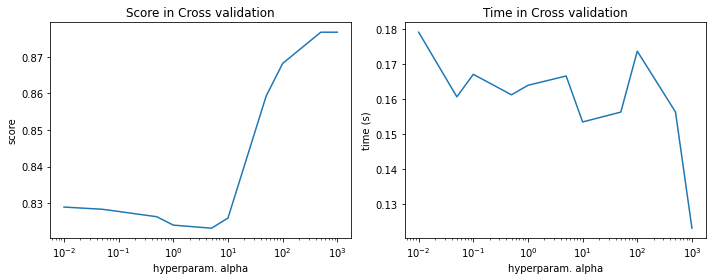

In [118]:
param_grid_bayes = {"alpha":[0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]}
dict_log_param_bayes = {'alpha': True}
CV_dict_bayes = {}
for model in [BernoulliNB(binarize=1), 
              ComplementNB(norm=True), 
              MultinomialNB()]:
    model_name = str(model).split("(")[0]
    print(model_name)
    CV_model = GridSearchCV(model, param_grid_bayes, n_jobs=8, cv=5)
    CV_model.fit(X_train, y_train)
    CV_dict_bayes[model_name] = CV_model

    plot_cv_res(CV_model.cv_results_, dict_log_param_bayes)
    plt.tight_layout()
    plt.show()

BernoulliNB


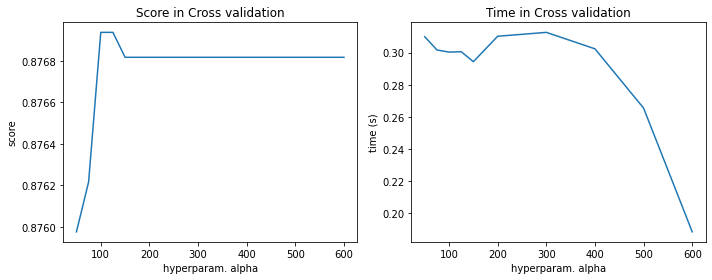

ComplementNB


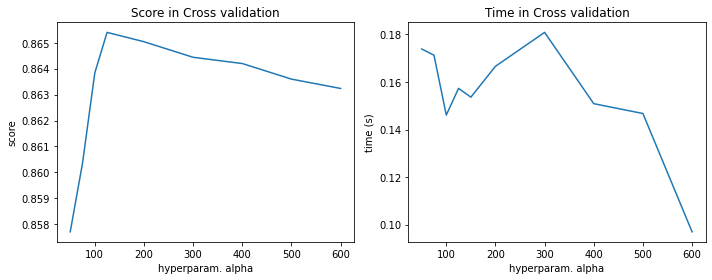

MultinomialNB


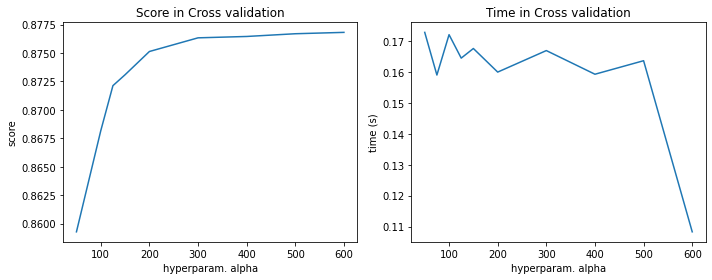

In [99]:
param_grid_bayes = {"alpha":[50,75,100,125,150,200,300,400,500,600]}
dict_log_param_bayes = {'alpha': False}
CV_dict_bayes = {}
for model in [BernoulliNB(binarize=1), 
              ComplementNB(norm=True), 
              MultinomialNB()]:
    model_name = str(model).split("(")[0]
    print(model_name)
    CV_model = GridSearchCV(model, param_grid_bayes, n_jobs=8, cv=5)
    CV_model.fit(X_train, y_train)
    CV_dict_bayes[model_name] = CV_model

    plot_cv_res(CV_model.cv_results_, dict_log_param_bayes)
    plt.tight_layout()
    plt.show()

In [110]:
for model in [BernoulliNB(binarize=1), 
              ComplementNB(norm=True), 
              MultinomialNB()]:
    model_name = str(model).split("(")[0]
    best_params = CV_dict_bayes[model_name].best_params_
    print(model_name, best_params)
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    print("Accuracy with best params", 
          np.round(model.score(X_test, y_test),3),
          "on test set")
    print()

BernoulliNB {'alpha': 100}
Accuracy with best params 0.876 on test set

ComplementNB {'alpha': 125}
Accuracy with best params 0.862 on test set

MultinomialNB {'alpha': 600}
Accuracy with best params 0.877 on test set



<a id ="section3.2"></a>
[back to menu](#menu)

## 3.B Gradient Boosting uniclass : 
#### The model and its parameters 

In [405]:
n_estimators = 400
max_leaf_nodes = 4
max_depth = None

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_leaf_nodes = max_leaf_nodes, max_depth=max_depth, 
    n_iter_no_change = 100, random_state=10
)

## train : 
gradient_boosting.fit(X_train, y_train)

## test :
y_pred = gradient_boosting.predict(X_test)
print("Accuracy with default params", 
      gradient_boosting.score(X_test,y_test),
      "on test set")

#### Optimisation par validation croisée :
Une validation croisée permet de choisir les paramètres optimaux : 

In [421]:
param_grid = {"learning_rate" : [0.05, 0.1, 0.2, 0.5],
              "n_estimators" : [100,200,500],
              "max_depth" : [3,5,10]}

gradient_boosting = GradientBoostingClassifier(n_iter_no_change=100, random_state=10)
boost_CV = GridSearchCV(gradient_boosting, param_grid, n_jobs=8, cv=5)

boost_CV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_iter_no_change=100,
                                                  random_state=10),
             n_jobs=8,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.5],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 500]})

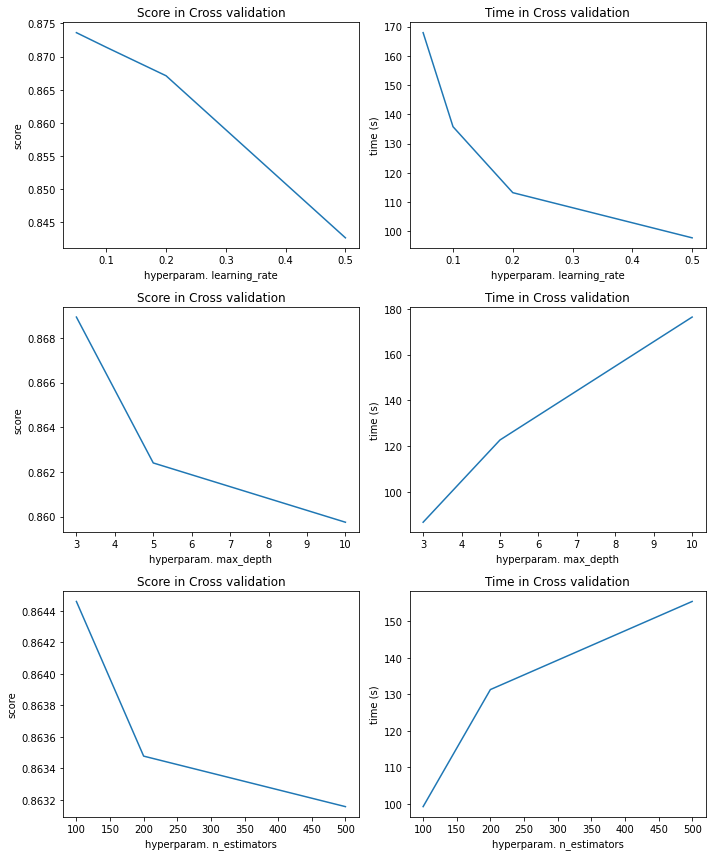

In [429]:
dict_log_param = {'learning_rate': False,
                     'n_estimators': False,
                     'max_depth': False}
plot_cv_res(boost_CV.cv_results_, dict_log_param)
plt.tight_layout()

In [434]:
boost_CV.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'deviance',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': 100,
 'estimator__random_state': 10,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingClassifier(n_iter_no_change=100, random_state=10),
 'n_jobs': 8,
 'param_grid': {'learning_rate': [0.05, 0.1, 0.2, 0.5],
  'n_estimators': [100, 200, 500],
  'max_depth': [3, 5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 's

La perte utilisée est la ["deviance"](https://stats.stackexchange.com/questions/157870/scikit-binomial-deviance-loss-function) et le score est l'accuracy. L'accuracy étant optimale à un, on veut qu'il soit le plus grand possible. Ainsi, les paramètres sont fixés à 
* n_estimator = 100
* max_depth = 3
* learning_rate = 0.05

Le meilleur modèle est relancé sur l'intégralité du jeu d'entrainement :

In [127]:
n_estimator = 100
max_depth = 3
learning_rate = 0.05
# best_params = boost_CV.best_params_
best_params = {"n_estimators" : 100,
                "max_depth" : 3,
                "learning_rate" : 0.05}
# print(boost_CV.best_params_)

gradient_boosting_model = GradientBoostingClassifier(n_iter_no_change=100, random_state=10, 
                                                     **best_params)
gradient_boosting_model.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.05, n_iter_no_change=100,
                           random_state=10)

Et les prédictions sur le jeu de test sont les suivantes : 

In [128]:
print("Accuracy with best params", 
      np.round(gradient_boosting_model.score(X_test,y_test),3))

Accuracy with best params 0.878


Le gradient boosting donne de meilleurs performances que les modèles de naive bayes.

<a id ="section3.3"></a>
[back to menu](#menu)


## 3.C Naive Bayes multiclass  : 

In [77]:
Y_train_multinom = Y_train.idxmax(axis=1)
Y_test_multinom = Y_test.idxmax(axis=1)

In [78]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes3 = MultinomialNB(alpha=0.1) 

## train : 
naive_bayes3.fit(X_train, Y_train_multinom)

## test :
Y_pred = naive_bayes3.predict(X_test)
print("Mean accuracy with default params", 
      naive_bayes3.score(X_test, Y_test_multinom),
      "on test set")

Mean accuracy with default params 0.523071377072819 on test set


Il aurait aussi été mieux de faire une validation croisée pour ces modèles, mais comme les arbres de décisions donnnent une meilleure accuracy moyenne, je passe directement à cette étape :

<a id ="section3.D"></a>
[back to menu](#menu)


## 3.D Arbre de décision (multiclasse) : 

<!-- La même méthodologie est utilisée pour le multiclass, avec le "HistGradientBoostingClassifier" [comme recommandé dans la doc sklearn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) -->
La même méthodologie est utilisée pour le multiclass avec un DecisionTreeClassifier. 
<!-- Pour éviter de trop biaisé l'ensemble d'apprentissage, les posts n'ayant aucun label parmis ceux sélectionnés dans Y_train : -->

In [15]:
from sklearn.tree import DecisionTreeClassifier
criterion = "gini"
max_leaf_nodes = 31
max_depth = None
min_samples_leaf = Y.shape[1]

decision_tree = DecisionTreeClassifier(
    criterion=criterion,
    max_leaf_nodes = max_leaf_nodes,
    max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf,
)

## train : 
decision_tree.fit(X_train, Y_train)

## test :
Y_pred = decision_tree.predict(X_test)
print("Mean accuracy with default params", 
      decision_tree.score(X_test,Y_test),
      "on test set")

Mean accuracy with default params 0.6149963950973324 on test set


In [16]:
no_label_train = Y_train[Y_train.sum(axis=1) == 0].index
Y_train2 = Y_train.drop(no_label_train, axis=0)
X_train2 = X_train.drop(no_label_train, axis=0)

In [17]:
decision_tree = DecisionTreeClassifier(
    criterion=criterion,
    max_leaf_nodes = max_leaf_nodes,
    max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf,
)

## train : 
decision_tree.fit(X_train2, Y_train2)

## test :
Y_pred = decision_tree.predict(X_test)
print("Mean accuracy with default params", 
      decision_tree.score(X_test,Y_test),
      "on test set")

Mean accuracy with default params 0.5580389329488104 on test set


#### Optimisation des paramètres du classifieur :

In [467]:
from sklearn.model_selection import GridSearchCV
param_grid = {"max_leaf_nodes" : [10,20,30,40,50,60,70,80,90,100],
              "max_depth" : [2,3,4,6,8,10]}

decision_tree = DecisionTreeClassifier(criterion="gini")
dtree_CV = GridSearchCV(decision_tree, param_grid, n_jobs=8, cv=5)

dtree_CV.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'max_depth': [2, 3, 4, 6, 8, 10],
                         'max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                            100]})

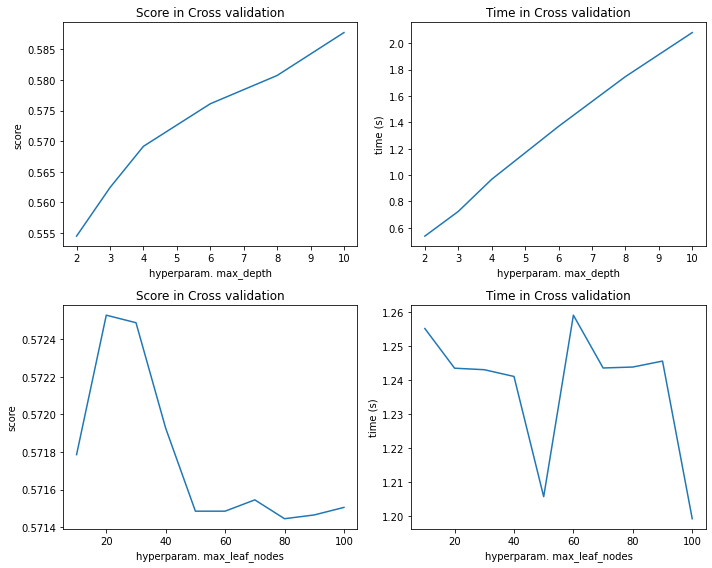

In [468]:
dict_log_param2 = {'max_leaf_nodes': False,
                  'max_depth': False}
plot_cv_res(dtree_CV.cv_results_, dict_log_param2)
plt.tight_layout()

Il faut ajuster le nombre de feuille maximale par noeud, entre 10 et 30. La profondeur d'arbre peut aussi être un peu augmentée.

In [469]:
param_grid = {"max_leaf_nodes" : np.arange(10,30,2),
              "max_depth" : [10, 20, 30]}

decision_tree = DecisionTreeClassifier(criterion="gini")
dtree_CV = GridSearchCV(decision_tree, param_grid, n_jobs=8, cv=5)

dtree_CV.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'max_depth': [10, 20, 30],
                         'max_leaf_nodes': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])})

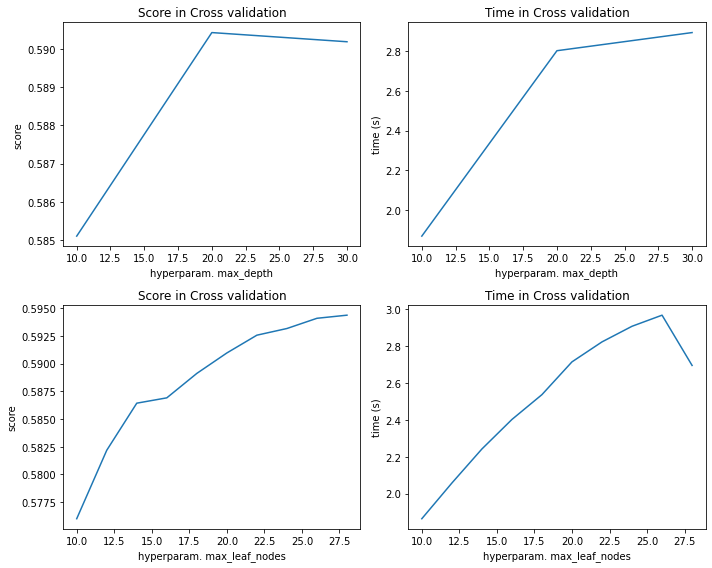

In [578]:
dict_log_param2 = {'max_leaf_nodes': False,
                  'max_depth': False}
plot_cv_res(dtree_CV.cv_results_, dict_log_param2)
plt.tight_layout()

In [555]:
max_depth = 30
max_leaf_nodes = 28
decision_tree.best_params_

{'max_depth': 30, 'max_leaf_nodes': 28}

In [24]:
decision_tree_model = DecisionTreeClassifier(criterion="gini", ** {'max_depth': 30, 'max_leaf_nodes': 28})
decision_tree_model.fit(X_train, Y_train)

## test :
Y_pred = decision_tree_model.predict(X_test)
print("Mean accuracy with default params", 
      decision_tree_model.score(X_test,Y_test),
      "on test set")

Mean accuracy with default params 0.6146359048305696 on test set


#### Comparaison sur le test set :

In [25]:
Y_pred = pd.DataFrame(Y_pred, index = test_index, columns=Y_test.columns)
Y_pred.head()

,linux,language,microsoft,micro_service,create_website,python_website,ruby,tests,python,computer_architecture,multimedia,object_oriented
52583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
## add a "wihtout classif" label:
test_no_classif = Y_test[Y_test.sum(axis=1)==0].index
Y_test2 = Y_test.copy()
Y_test2.loc[test_no_classif,"no_label"] = 1
Y_test2 = Y_test2.fillna(0)

pred_no_classif = Y_pred[Y_pred.sum(axis=1)==0].index
Y_pred2 = Y_pred.copy()
Y_pred2.loc[pred_no_classif,"no_label"] = 1
Y_pred2 = Y_pred2.fillna(0)

In [48]:
labels=list(Y_pred.columns.values)
print(sklearn.metrics.classification_report(y_true = Y_test, y_pred=Y_pred, 
                                            zero_division=False, target_names=labels))

                       precision    recall  f1-score   support

                linux       0.57      0.22      0.32       192
             language       0.00      0.00      0.00       162
            microsoft       0.63      0.15      0.24       175
        micro_service       0.63      0.27      0.38       116
       create_website       0.77      0.65      0.71       151
       python_website       0.49      0.17      0.25       122
                 ruby       0.89      0.56      0.68        97
                tests       0.78      0.33      0.46        86
               python       0.71      0.14      0.24       104
computer_architecture       0.86      0.17      0.29       172
           multimedia       0.85      0.60      0.70        65
      object_oriented       0.65      0.42      0.51        67

            micro avg       0.71      0.27      0.40      1509
            macro avg       0.65      0.31      0.40      1509
         weighted avg       0.62      0.27      0.36 

In [49]:
## consider unlabelled as a new class :
labels2=list(Y_pred2.columns.values)
print(sklearn.metrics.classification_report(y_true=Y_test2, y_pred=Y_pred2, 
                                            zero_division=False, target_names=labels2))

                       precision    recall  f1-score   support

                linux       0.57      0.22      0.32       192
             language       0.00      0.00      0.00       162
            microsoft       0.63      0.15      0.24       175
        micro_service       0.63      0.27      0.38       116
       create_website       0.77      0.65      0.71       151
       python_website       0.49      0.17      0.25       122
                 ruby       0.89      0.56      0.68        97
                tests       0.78      0.33      0.46        86
               python       0.71      0.14      0.24       104
computer_architecture       0.86      0.17      0.29       172
           multimedia       0.85      0.60      0.70        65
      object_oriented       0.65      0.42      0.51        67
             no_label       0.64      0.93      0.76      1513

            micro avg       0.65      0.60      0.63      3022
            macro avg       0.65      0.35      0.43 

In [576]:
param_grid = {"max_leaf_nodes" : np.arange(10,30,2),
              "max_depth" : [10, 20, 30]}

decision_tree = DecisionTreeClassifier(criterion="entropy")
dtree_CV = GridSearchCV(decision_tree, param_grid,n_jobs=8, cv=5)

dtree_CV.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             n_jobs=8,
             param_grid={'max_depth': [10, 20, 30],
                         'max_leaf_nodes': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])})

In [577]:
dtree_CV.best_params_

{'max_depth': 30, 'max_leaf_nodes': 28}